# **Topic Modeling with Quantized LLMs**
*Create easily interpretable topics with BERTopic and LLMs*
<br>

<img src="https://pbs.twimg.com/media/GDA2JQoX0AElWoq?format=jpg&name=large">


---
        
💡 **NOTE**: We will want to use a GPU to run both 7B LLMs as well as BERTopic for this use case. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---

We will start by installing a number of packages that we are going to use throughout this example:

In [1]:
"""
#%%capture
# BERTopic + llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python --force-reinstall --no-cache-dir
!pip install bertopic datasets

# DataMapPlot
#!git clone https://github.com/TutteInstitute/datamapplot.git
#!pip install datamapplot/.
!pip install datamapplot
"""

'\n#%%capture\n# BERTopic + llama-cpp-python\n!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python --force-reinstall --no-cache-dir\n!pip install bertopic datasets\n\n# DataMapPlot\n#!git clone https://github.com/TutteInstitute/datamapplot.git\n#!pip install datamapplot/.\n!pip install datamapplot\n'

In [2]:
"""
# GPU-accelerated HDBSCAN + UMAP
!pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64
"""

'\n# GPU-accelerated HDBSCAN + UMAP\n!pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com\n!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com\n!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com\n!pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64\n'

In [3]:
from datasets import load_dataset
import pandas as pd
from llama_cpp import Llama
from bertopic.representation import KeyBERTInspired, LlamaCPP


# 📄 **Data**

We are going to apply topic modeling on a number of ArXiv abstracts. They are a great source for topic modeling since they contain a wide variety of topics and are generally well-written.

In [4]:

# ArXiv ML Documents
#docs = load_dataset("CShorten/ML-ArXiv-Papers")["train"]["abstract"]

csv_path = 'data/Trustpilot/www.darty.com.xlsx'
feedbacks_df = pd.read_excel(csv_path)
feedbacks_df['Date'] = pd.to_datetime(feedbacks_df['Date'], format='%B %d, %Y', errors='coerce')
feedbacks_df['Content'] = feedbacks_df['Content'].fillna('')
docs = feedbacks_df['Content']

In [5]:
docs

0       Toujours un très bon service de Darty. La récu...
1       Très très apprécié d’installer la machine et r...
2       Commandée sur le site de Darty machine à laver...
3       Le 8 nov 2023 j'achète un ordinateur chez Dart...
4       Fausse vente de crédit gratuitNon réponse du m...
                              ...                        
8974    Bonne qualité des communications téléphoniques...
8975    je viens de souscrire aà l'offre darty interne...
8976    service SAV  LUXEMBOURG archi nul totalement i...
8977    Je suis toujours très satisfaite de ce site, r...
8978    J'ai acheté un aspirateur "suceur" de marque H...
Name: Content, Length: 8979, dtype: object

# 🦙 **Quantized LLM**

To use a quantized LLMs, we make use of the `GGUF` format together with `llama-cpp-python`. When you access any of [TheBloke's quantized models](https://huggingface.co/TheBloke), you can click on files and find specific quantized formats. We are going with a 4-bit quantized model:

In [6]:
#!wget https://huggingface.co/TheBloke/OpenHermes-2.5-Mistral-7B-GGUF/resolve/main/openhermes-2.5-mistral-7b.Q4_K_M.gguf
# !wget https://huggingface.co/TheBloke/dolphin-2.7-mixtral-8x7b-GGUF/resolve/main/dolphin-2.7-mixtral-8x7b.Q3_K_M.gguf

Next, we load the model using `llama-cpp-python`:

In [7]:
#model_path="/home/maitre/Documents/Models/mistral-7b-instruct-v0.1.Q5_K_M.gguf"
model_path="/home/maitre/Documents/Development/text-generation-webui/models/mixtral-8x7b-instruct-v0.1.Q3_K_M.gguf"
# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path=model_path, n_gpu_layers=25, n_ctx=16384, stop=["Q:", "\n"])

ggml_init_cublas: GGML_CUDA_FORCE_MMQ:   no
ggml_init_cublas: CUDA_USE_TENSOR_CORES: yes
ggml_init_cublas: found 1 CUDA devices:
  Device 0: NVIDIA GeForce RTX 3090, compute capability 8.6, VMM: yes
llama_model_loader: loaded meta data with 26 key-value pairs and 995 tensors from /home/maitre/Documents/Development/text-generation-webui/models/mixtral-8x7b-instruct-v0.1.Q3_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mixtral-8x7b-instruct-v0.1
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_co

We pass the LLM to BERTopic with a custom prompt. Let's add `KeyBERTInspired` representations to compare the LLM representations with:

In [8]:

prompt_english = """ Q:
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the above information, can you give a short label of the topic of at most 5 words?
A:
"""

prompt = """ Q:
J'ai le regroupement de commentaires suivants :
[DOCUMENTS]

Ce regroupement contient les mots-clés suivants : '[KEYWORDS]'.

Sur la base des informations ci-dessus, nomme cette cétegorie de commentaires.
A:
"""

representation_model = {
    "KeyBERT": KeyBERTInspired(),
    "LLM": LlamaCPP(llm, prompt=prompt),
}

# 🗨️ **BERTopic**

By pre-calculating the embeddings for each document, we can speed-up additional exploration steps and use the embeddings to quickly iterate over BERTopic's hyperparameters if needed.

🔥 **TIP**: You can find a great overview of good embeddings for clustering on the [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

In [9]:
from sentence_transformers import SentenceTransformer
from cuml.manifold import UMAP
from cuml.cluster import HDBSCAN
import pickle
# from umap import UMAP
# from hdbscan import HDBSCAN


In [10]:

# Pre-calculate embeddings
#embedding_model = SentenceTransformer("BAAI/bge-small-en")
#embedding_model = SentenceTransformer("Salesforce/SFR-Embedding-Mistral")
embedding_model = SentenceTransformer("OrdalieTech/Solon-embeddings-large-0.1")
#embedding_model = SentenceTransformer("intfloat/multilingual-e5-large")

embeddings = embedding_model.encode(docs, show_progress_bar=True)

# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

Batches:   0%|          | 0/281 [00:00<?, ?it/s]

In [11]:
"""
with open('embeddings_abstracts_mixtral', 'wb') as f:
    pickle.dump(embeddings, f)

with open('embeddings_abstracts_mixtral', 'rb') as f:
    embeddings = pickle.load(f)
    """

In [13]:
# Define sub-models
min_cluster_size=20 #400
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# 🔥 **Training**

Now that we have our models prepared, we can start training our topic model! We supply BERTopic with the sub-models of interest, run `.fit_transform`, and see what kind of topics we get.

In [14]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)

2024-02-26 18:31:47,978 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


2024-02-26 18:31:48,092 - BERTopic - Dimensionality - Completed ✓
2024-02-26 18:31:48,093 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-26 18:31:48,273 - BERTopic - Cluster - Completed ✓
2024-02-26 18:31:48,277 - BERTopic - Representation - Extracting topics from clusters using representation models.
  0%|          | 0/27 [00:00<?, ?it/s]
llama_print_timings:        load time =    2656.60 ms
llama_print_timings:      sample time =       4.51 ms /    16 runs   (    0.28 ms per token,  3544.53 tokens per second)
llama_print_timings: prompt eval time =   19090.04 ms /  3278 tokens (    5.82 ms per token,   171.71 tokens per second)
llama_print_timings:        eval time =    1123.39 ms /    15 runs   (   74.89 ms per token,    13.35 tokens per second)
llama_print_timings:       total time =   20264.56 ms /  3293 tokens
  4%|▎         | 1/27 [00:20<08:47, 20.27s/it]Llama.generate: prefix-match hit

llama_print_timings:        load time =    2656.60 ms
llama_print_ti

Now that we are done training our model, let's see what topics were generated:

In [ ]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,LLM,Representative_Docs
0,-1,3012,-1_de_le_et_la,"[de, le, et, la, je, un, darty, pas, que, en]","[remboursement, livraison, darty, magasin, ven...",[Voici une phrase possible qui décrit ces comm...,[Je suis allé sur le site Darty.com pour comma...
1,0,1392,0_très_et_bon_rapide,"[très, et, bon, rapide, livraison, bien, produ...","[satisfaite, super, impeccable, recommande, ag...",[La catégorie de commentaires décrit un magasi...,"[Un très bon magasin, à votre écoute, très bon..."
2,1,816,1_lave_de_le_machine,"[lave, de, le, machine, la, et, un, linge, pas...","[laver, garantie, darty, machine, lave, linge,...",[La catégorie de commentaires décrit des probl...,[Je suis cliente depuis 30 ans chez Darty. Il ...
3,2,526,2_frigo_le_de_un,"[frigo, le, de, un, réfrigérateur, la, et, pas...","[livraison, frigo, darty, livreurs, réfrigérat...","[La livraison d'un réfrigérateur chez Darty, ,...",[voila jeudi 27/08 je commande un frigo le mie...
4,3,432,3_téléphone_le_de_un,"[téléphone, le, de, un, je, et, que, darty, es...","[samsung, garantie, smartphone, iphone, téléph...",[Voici une phrase qui décrit cette catégorie d...,[J'ai commandé sur la Marketplace DARTY un tél...
5,4,401,4_darty_très_et_de,"[darty, très, et, de, je, recommande, bon, mer...","[darty, produits, produit, livraison, satisfai...","[""Les clients sont très satisfaits des produit...",[Comme toujours je suis très satisfait de Dart...
6,5,326,5_de_assurance_je_que,"[de, assurance, je, que, un, mois, et, ai, dar...","[arnaque, paiement, assurances, assurance, abo...",[Un contrat d'assurance d'un mois chez Darty q...,"[Suite à un achat chez eux, une assurance m'a ..."
7,6,309,6_commande_le_de_service,"[commande, le, de, service, pas, et, en, clien...","[remboursement, livraison, amazon, produit, ma...",[Le regroupement décrit des expériences négati...,[Suite a l'achat sur internet d'un PC portable...
8,7,307,7____,"[, , , , , , , , , ]","[, , , , , , , , , ]",[Une catégorie de commentaires qui concernent ...,"[, , ]"
9,8,261,8_tv_de_la_le,"[tv, de, la, le, téléviseur, et, je, que, pour...","[garantie, samsung, téléviseur, livraison, dar...",[Ces commentaires concernent des expériences n...,[Avant de commander vos courses de Noël sur le...


# 📊 Visualization with DataMapPlot

In [ ]:
import PIL
import numpy as np
import requests

# Prepare logo
bertopic_logo_response = requests.get(
    "https://raw.githubusercontent.com/MaartenGr/BERTopic/master/images/logo.png",
    stream=True,
    headers={'User-Agent': 'My User Agent 1.0'}
)
bertopic_logo = np.asarray(PIL.Image.open(bertopic_logo_response.raw))

We can use the labels created by the LLM and assign them to topics that we have created:

(<Figure size 1200x1200 with 1 Axes>,
 <Axes: title={'left': 'Topics labeled with `openhermes-2.5-mistral-7b`'}>)

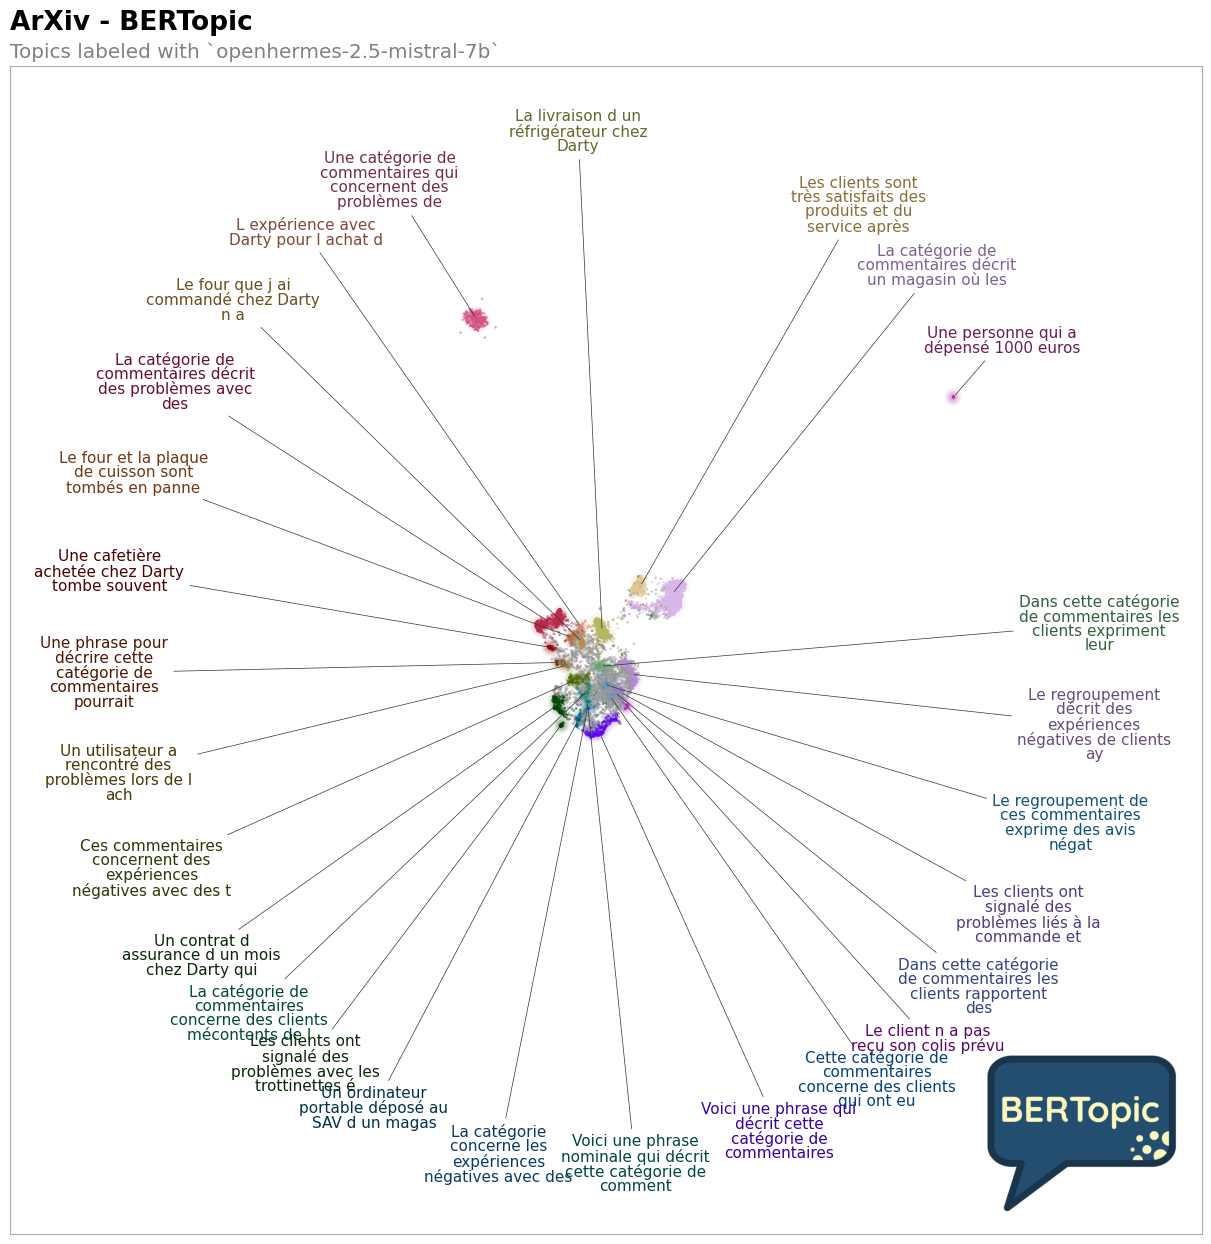

In [ ]:
import datamapplot
import re

# Create a label for each document
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]

# Run the visualization
datamapplot.create_plot(
    reduced_embeddings,
    all_labels,
    label_font_size=11,
    title="ArXiv - BERTopic",
    sub_title="Topics labeled with `openhermes-2.5-mistral-7b`",
    label_wrap_width=20,
    use_medoids=True,
    logo=bertopic_logo,
    logo_width=0.16
)